<a href="https://colab.research.google.com/github/yyqq-git/mit-15.773/blob/main/HODL_SP24_Lec_03B_Learning_an_Image_Classification_Model_from_Scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Learning an Image Classification Model from Scratch

* Based on [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python-second-edition?gclid=CjwKCAjw9aiIBhA1EiwAJ_GTSlKgxc4qopKHPsFWryOoTz7fvhvhzYSjEsgQ-bG1R51QSGppISywpBoClcIQAvD_BwE) by Francois Chollett


### The Fashion MNIST dataset



The [fashion_mnist](https://github.com/zalandoresearch/fashion-mnist) dataset consists of 70,000 images of clothing items across 10 categories.

![Fashion MNIST](https://raw.githubusercontent.com/zalandoresearch/fashion-mnist/master/doc/img/fashion-mnist-sprite.png)



<br>

Luckily for us, this dataset is available in a convenient format through Keras, so we will load it and take a look.

But first, let's get some technical preliminaries out of the way.



---



---



---


We will first import the following packages and set the seed for the random number generator.

In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# initialize the seeds of different random number generators so that the
# results will be the same every time the notebook is run
keras.utils.set_random_seed(42)

With the technical preliminaries out of the way, let's load the dataset and take a look.

In [ ]:
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


In [ ]:
print(x_train.shape, y_train.shape)

(60000, 28, 28) (60000,)


There are 60,000 images in the training set, each of which is a 28x28 matrix.

In [ ]:
print(x_test.shape, y_test.shape)

(10000, 28, 28) (10000,)


The remaining 10,000 images are in the test set.

<br>

OK, let's look at the first 10 rows of the dependent variable $y$.





In [ ]:
y_train[:10]

array([9, 0, 0, 3, 0, 2, 7, 2, 5, 5], dtype=uint8)

**What do these numbers mean?**

According to the [Fashion MNIST Github site](https://github.com/zalandoresearch/fashion-mnist#labels), this is what each number 0-9 corresponds to:

| Label  | Description  |
|---|---|
|  0 | T-shirt/top  |
|  1 |  Trouser |
|  2 |   Pullover |
|  3 |  Dress |
|  4 |  Coat |
|  5 |  Sandal |
|  6 |   Shirt |
|  7 |  Sneaker |
|  8 |   Bag |
|  9 |  Ankle boot |

Let's create a little Python list so that we can go from numbers to descriptions easily.

In [ ]:
labels = ["T-shirt/top",
          "Trouser",
          "Pullover",
          "Dress",
          "Coat",
          "Sandal",
          "Shirt",
          "Sneaker",
          "Bag",
          "Ankle boot"]



Given a number, the description is now a simple look-up. Let's see what the very first training example is about.

In [ ]:
labels[y_train[0]]

'Ankle boot'

The very first image is an "Ankle boot"!

Let's take a look at the **raw data** for the image.

In [ ]:
print(x_train[0])

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   1   0   0  13  73   0
    0   1   4   0   0   0   0   1   1   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   3   0  36 136 127  62
   54   0   0   0   1   3   4   0   0   3]
 [  0   0   0   0   0   0   0   0   0   0   0   0   6   0 102 204 176 134
  144 123  23   0   0   0   0  12  10   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0 155 236 207 178
  107 156 161 109  64  23  77 130  72  15]
 [  0   0   0   0   0   0   0   0   0   0   0   1   0  69 207 223 218 216
  216 163 127 121 122 146 141  88 172  66]
 [  0   0   0   0   0   0   0   0   0   1   1   1   0 200 232 23

Let's look at the first 25 images.



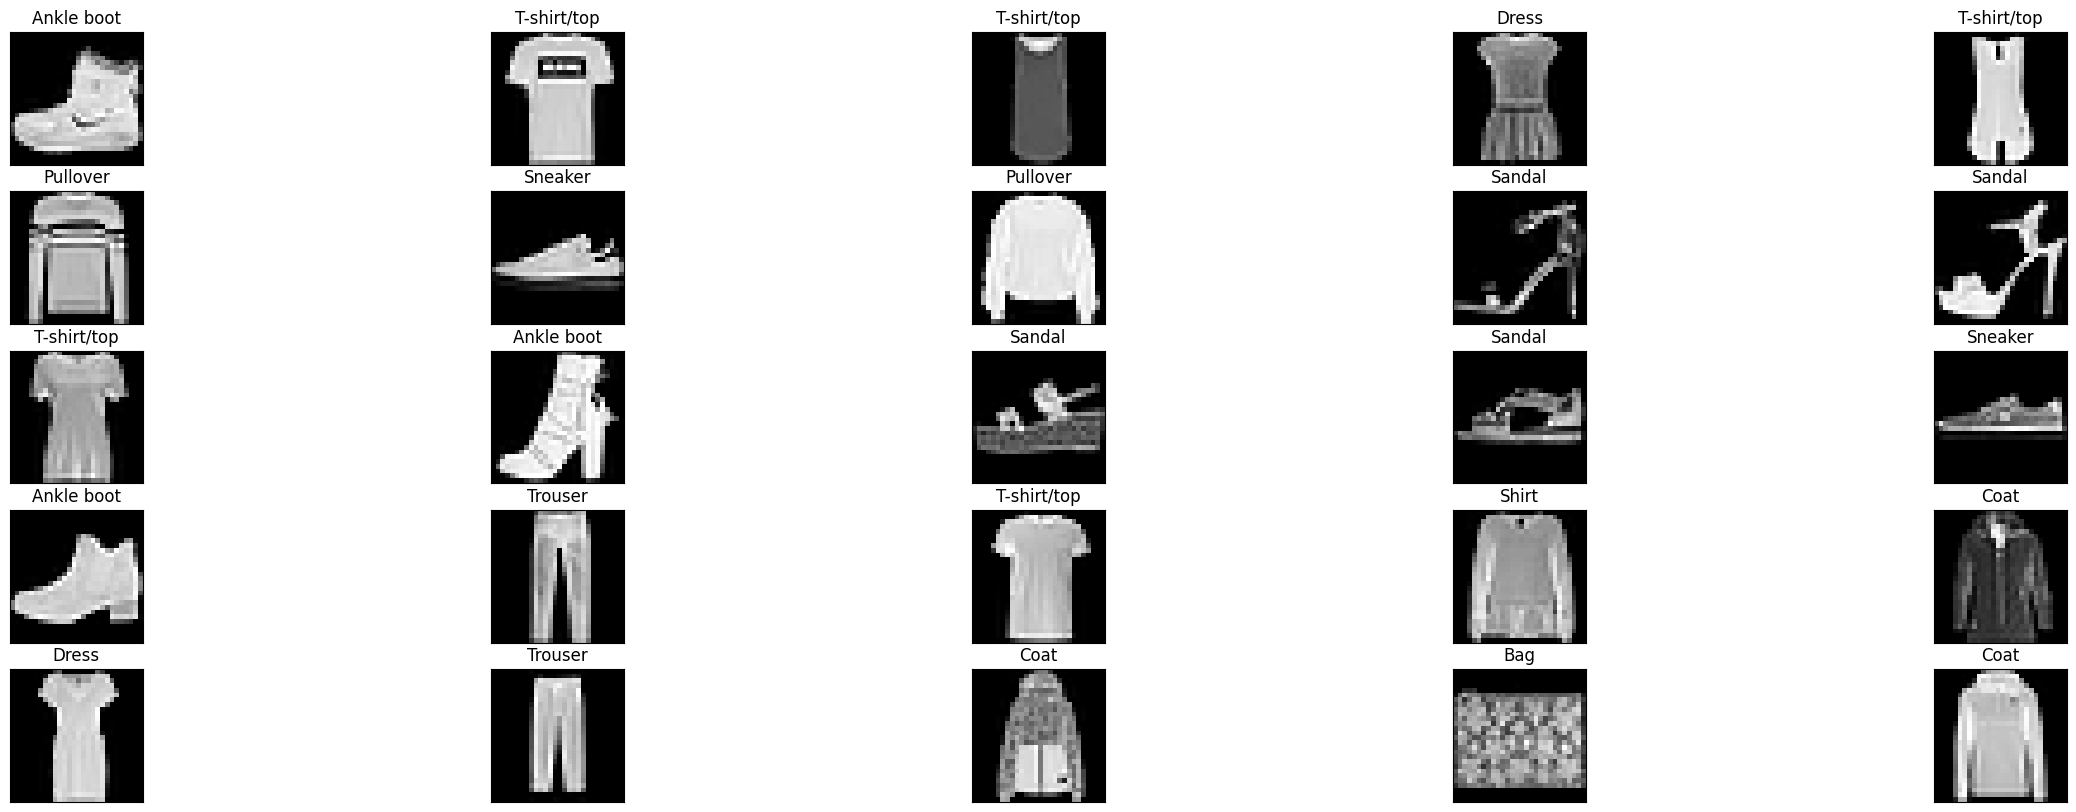

In [ ]:
fig, ax = plt.subplots(5, 5, figsize=(30, 10))
for i in range(25):
  axc = ax[i//5, i%5]
  axc.imshow(x_train[i], cmap="gray")
  axc.set_title(f"{labels[y_train[i]]}")
  axc.set_xticks([])
  axc.set_yticks([])

## NN Model

### Data Prep

**Tip**: NNs learn best when each independent variable is in a small range. So, standardize them by either
- subtracting the mean and dividing by the standard deviation or
- if they are in a guaranteed range, just divide by the max value.

The inputs here range from 0 to 255. Let's normalize to the 0-1 range by dividing everything by 255.

In [ ]:
x_train = x_train/ 255.0
x_test = x_test/ 255.0

### Define Model in Keras

Recap of the NN we designed in class:

* The input will be 28 x 28 matrices of numbers. These will have to be *flattened* into a loooong vector and then fed to the next layer.
* We will use just a single hidden layer.
* Since this is a *multi-class classification problem* (e.g., we need to predict one of 10 clothing categories), the output layer has to produce a 10-element vector of probabilities that sum up to 1.0  => we will use the *softmax* layer.

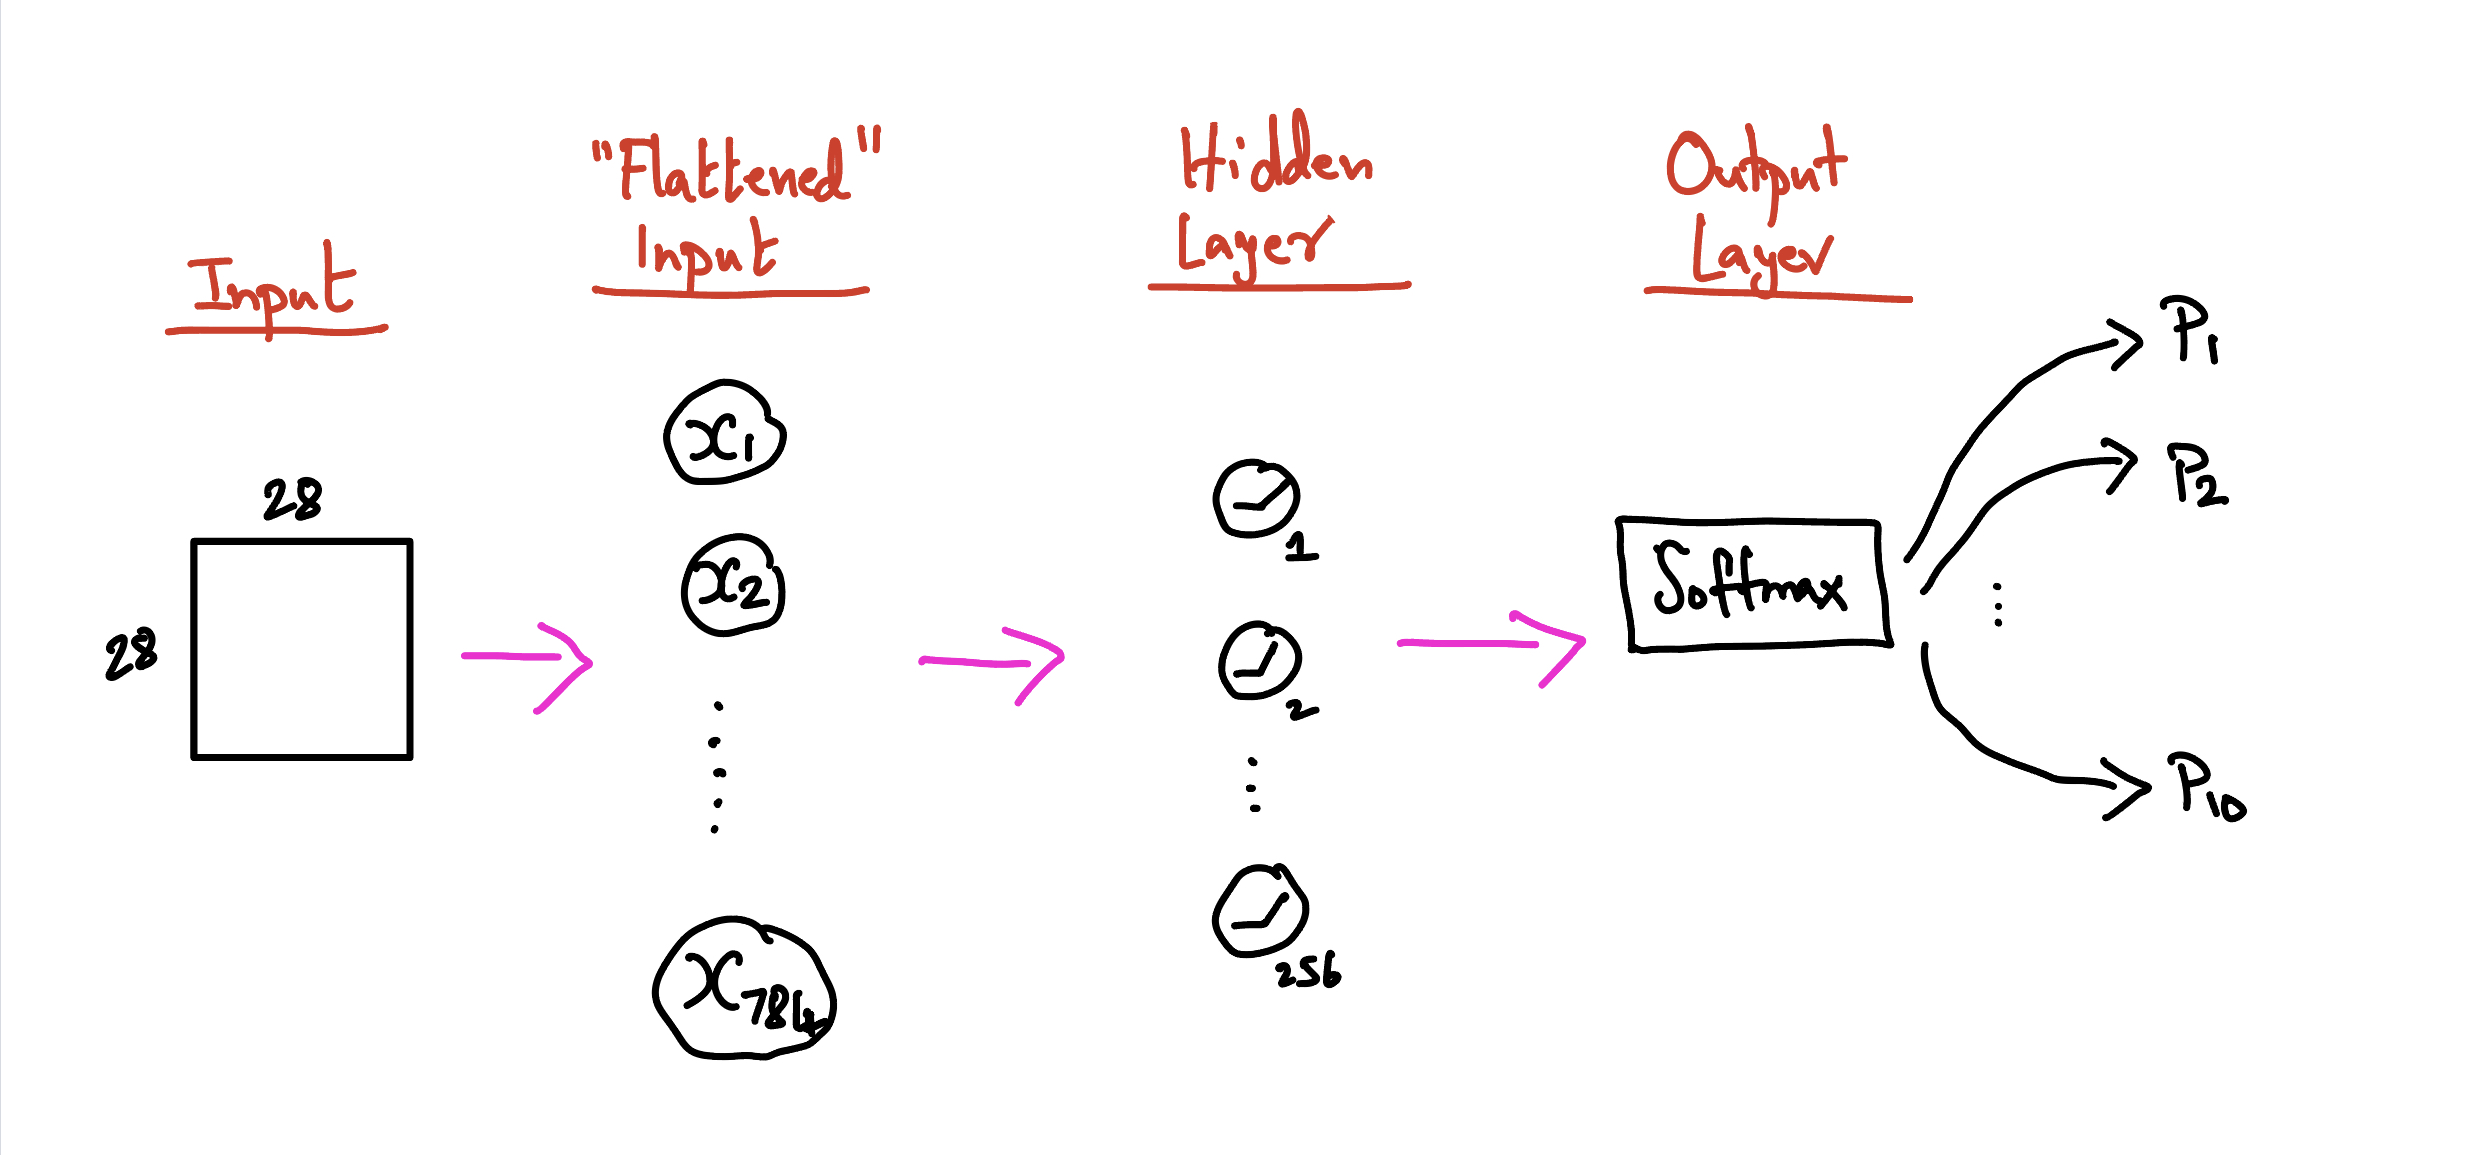

In [ ]:
28 * 28


784

Let's "translate" this to Keras.

In [ ]:
# define the input layer
input = keras.Input(shape=(28,28))

# convert the 28 x 28 matrix of numbers into a loooooooong vector
h = keras.layers.Flatten()(input)

# feed the long vector to the hidden layer
h = keras.layers.Dense(256, activation="relu", name="Hidden")(h)

# feed the output of the hidden layer to the output layer
output = keras.layers.Dense(10, activation="softmax", name="Output")(h)

# tell Keras that this (input,output) pair is your model
model = keras.Model(input, output)

The `model.summary()` command is a good way to get a quick overview of what you have defined.

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28)]          0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 Hidden (Dense)              (None, 256)               200960    
                                                                 
 Output (Dense)              (None, 10)                2570      
                                                                 
Total params: 203530 (795.04 KB)
Trainable params: 203530 (795.04 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Let's hand-calculate the number of parameters to verify.

In [ ]:
(784 * 256 + 256) + (256 * 10 + 10)

203530

We can "visualize" the network graphically as well using Keras' `plot_model` function.

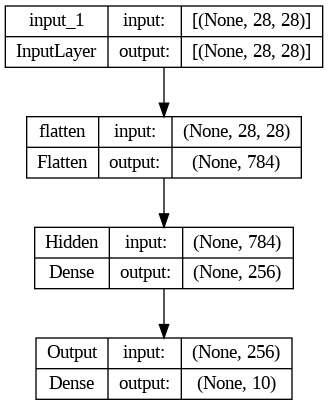

In [ ]:
keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

### Set Optimization Parameters

Now that the model is defined, we need to tell Keras three things:

*   What **loss function** to use
*   Which **optimizer** to use - we will again use **Adam** which is an excellent set-and-forget choice
*   What **metrics** you want Keras to report out - in classification problems like this one, Accuracy is usually the metric you want to see.


Since our output variable is categorical with 10 levels, we will select the `sparse_categorical_crossentropy` loss function. Recall this slide from the lecture:


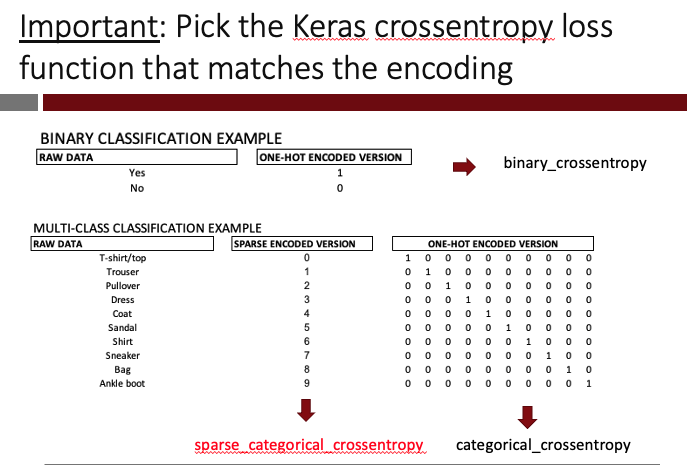

In [ ]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

### Train the Model!

* The *batch size*: 32 or 64 are commonly used
* The number of *epochs* i.e., how many passes through the training data: we will start with 20.
* To check for overfitting, we will ask Keras to automatically use 20% of the training data points as a validation set

---

OK, let's train the model using the `model.fit` function!


In [ ]:
batch_size = 64
epochs = 20

history = model.fit(x_train,
                    y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_split=0.2)

Epoch 1/20
750/750 [==============================] - 5s 4ms/step - loss: 0.5162 - accuracy: 0.8187 - val_loss: 0.4108 - val_accuracy: 0.8565
Epoch 2/20
750/750 [==============================] - 3s 3ms/step - loss: 0.3855 - accuracy: 0.8614 - val_loss: 0.3837 - val_accuracy: 0.8627
Epoch 3/20
750/750 [==============================] - 3s 3ms/step - loss: 0.3437 - accuracy: 0.8749 - val_loss: 0.3443 - val_accuracy: 0.8762
Epoch 4/20
750/750 [==============================] - 3s 4ms/step - loss: 0.3170 - accuracy: 0.8843 - val_loss: 0.3385 - val_accuracy: 0.8782
Epoch 5/20
750/750 [==============================] - 2s 3ms/step - loss: 0.2968 - accuracy: 0.8907 - val_loss: 0.3496 - val_accuracy: 0.8777
Epoch 6/20
750/750 [==============================] - 2s 3ms/step - loss: 0.2786 - accuracy: 0.8968 - val_loss: 0.3164 - val_accuracy: 0.8847
Epoch 7/20
750/750 [==============================] - 2s 3ms/step - loss: 0.2657 - accuracy: 0.9018 - val_loss: 0.3131 - val_accuracy: 0.8858
Epoch 

Let's plot the loss and accuracy curves to see if ***overfitting*** is going on and if **early stopping** may be needed.

We will use the code from the previous colab but put it in a couple of functions to minimize typing.

In [ ]:
def plot_loss_curves(history):
  plt.clf()
  history_dict = history.history
  loss_values = history_dict["loss"]
  val_loss_values = history_dict["val_loss"]
  epochs = range(1, len(loss_values) + 1)
  plt.plot(epochs, loss_values, "bo", label="Training loss")
  plt.plot(epochs, val_loss_values, "b", label="Validation loss")
  plt.title("Training and validation loss")
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.legend()
  plt.show()

In [ ]:
def plot_acc_curves(history):
  plt.clf()
  history_dict = history.history
  acc = history_dict["accuracy"]
  val_acc = history_dict["val_accuracy"]
  epochs = range(1, len(acc) + 1)
  plt.plot(epochs, acc, "bo", label="Training acc")
  plt.plot(epochs, val_acc, "b", label="Validation acc")
  plt.title("Training and validation accuracy")
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  plt.legend()
  plt.show()

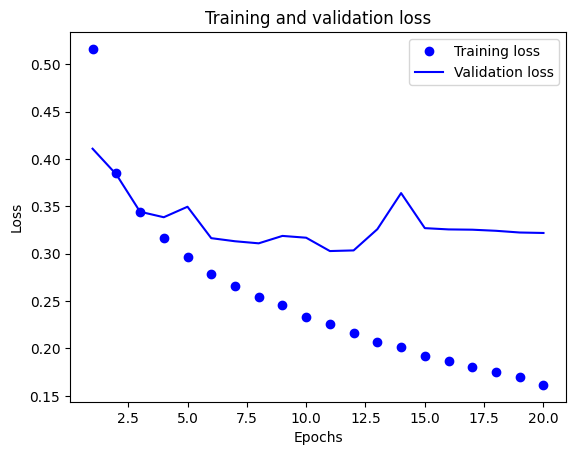

In [ ]:
plot_loss_curves(history)

Do you think there's overfitting?

If you think there's overfitting at epoch N, we could go back, re-initialize the model and just run it for  N epochs - that would be an example of **early stopping**.

Let's look at the accuracy curves as well.

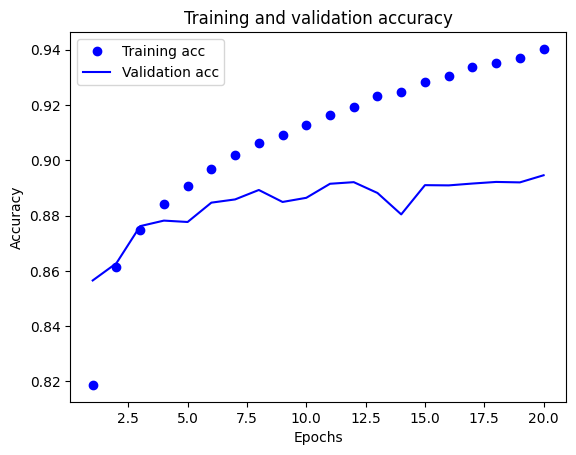

In [ ]:
plot_acc_curves(history)

What do you think? Are we overfitting?

### Evaluate the Model

Let's see **how well the model does on the test set**.


In [ ]:
model.evaluate(x_test, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.3604 - accuracy: 0.8845


[0.3603815734386444, 0.8845000267028809]


**Is this impressive? What's a good baseline to compare it to?**



### If we want to add a **second** hidden layer, how easy is it?

In [ ]:
# define the input layer
input = keras.Input(shape=(28,28))

# convert the 28 x 28 matrix of numbers into a long vector
h = keras.layers.Flatten()(input)

# feed the long vector to the first hidden layer
h = keras.layers.Dense(256, activation="relu", name="Hidden_1")(h)

# THIS IS THE ADDITIONAL LINE
# feed the output of the first hidden layer to the second hidden layer
h = keras.layers.Dense(256, activation="relu", name="Hidden_2")(h)

# feed the output of the second hidden layer to the output layer
output = keras.layers.Dense(10, activation="softmax", name="Output")(h)


# tell Keras that this (input,output) pair is your model
model = keras.Model(input, output)

In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28)]          0         
                                                                 
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 Hidden_1 (Dense)            (None, 256)               200960    
                                                                 
 Hidden_2 (Dense)            (None, 256)               65792     
                                                                 
 Output (Dense)              (None, 10)                2570      
                                                                 
Total params: 269322 (1.03 MB)
Trainable params: 269322 (1.03 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


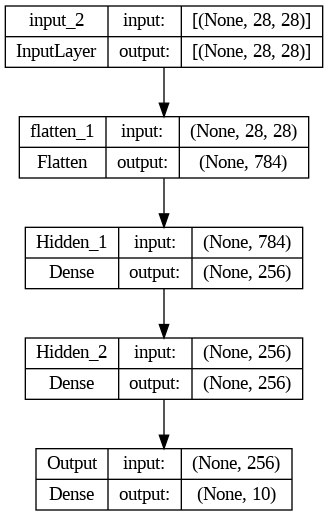

In [ ]:
keras.utils.plot_model(model, show_shapes=True)

You are welcome to train the model above and see how well it does on the test set.

Use these commands (as we did above):


*   `model.compile`
*   `model.fit`
*   `model.evaluate`



